# Uncertainty of soil water content estimated from epithermal neutrons

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import bokeh

ModuleNotFoundError: No module named 'bokeh'

In [24]:
def get_N(N0=None, thc=None, rhob=None, a0=0.0808, a1=0.372, a2=0.115, rhow=1000.):
    return N0 * ( (a0 / (thc * rhow / rhob + a2)) + a1)

def N_error(N, a=24):
    return (np.sqrt(N*a) / a)
#    return (np.sqrt(N*a) / np.sqrt(a))

In [25]:
def dth_dN(N=None, N0=None, fs=None, rhob=None, mb=None, som=None, lw=None, a0=None, a1=None, a2=None, rhow=None):
    return 111.111 * a0 * rhob * (mb - 111.111) * fs * N0 / (rhow * (a1 * (mb-111.111) * N0 + 111.111 * fs * N )**2)

def dth_dN0(N=None, N0=None, fs=None, rhob=None, mb=None, som=None, lw=None, a0=None, a1=None, a2=None, rhow=None):
    return 111.111 * a0 * rhob * (mb - 111.111) * fs * N / (rhow * (a1 * (mb-111.111) * N0 + 111.111 * fs * N )**2)

def dth_dfs(N=None, N0=None, fs=None, rhob=None, mb=None, som=None, lw=None, a0=None, a1=None, a2=None, rhow=None):
    return 111.111 * a0 * rhob * (mb - 111.111) * N * N0 / (rhow * (a1 * (mb-111.111) * N0 + 111.111 * fs * N )**2)

def dth_dmb(N=None, N0=None, fs=None, rhob=None, mb=None, som=None, lw=None, a0=None, a1=None, a2=None, rhow=None):
    return 0.009 * a0 * rhob * fs * N * N0 / (rhow * (a1 * N0 * (0.009 * mb - 1) + fs * N)**2)

def dth_drhob(N=None, N0=None, fs=None, rhob=None, mb=None, som=None, lw=None, a0=None, a1=None, a2=None, rhow=None):
    return ((a0 / (fs * N / (N0 * (1. - 0.009*mb)) - a1)) - a2 - 0.556 * som - lw) / rhow

def dth_dsom(N=None, N0=None, fs=None, rhob=None, mb=None, som=None, lw=None, a0=None, a1=None, a2=None, rhow=None):
    return -0.556 * rhob / rhow

def dth_dlw(N=None, N0=None, fs=None, rhob=None, mb=None, som=None, lw=None, a0=None, a1=None, a2=None, rhow=None):
    return -rhob / rhow


def sigma_th(pars, sigmas):
    return np.sqrt( 
              dth_dfs(**pars)**2   * sigmas["fs"]**2   + \
              dth_dN(**pars)**2    * sigmas["N"]**2    + \
              dth_dN0(**pars)**2   * sigmas["N0"]**2   + \
              dth_dmb(**pars)**2   * sigmas["mb"]**2   + \
              dth_drhob(**pars)**2 * sigmas["rhob"]**2 + \
              dth_dsom(**pars)**2  * sigmas["som"]**2  + \
              dth_dlw(**pars)**2   * sigmas["lw"]**2
    )

In [26]:
def get_sigma_fs(fs, Ncal, a=24):
    """Error of fs for a given collocation interval a and a calibrator neutron intensity of Ncal
    
    The relative error of the target variable is the difference between 
    the relative error of the enumerator and the relative error of the denominator.
    """
    return fs * np.sqrt((1+fs)/(Ncal*a))
#    return (1 + np.sqrt(fs)) / (np.sqrt(Ncal*a))

In [27]:
def dth_dN_eff(N=None, Nc=None, rhob=None, thc=None, a0=None, a1=None, a2=None, rhow=None):
    return -a0 * rhob * Nc * (a2 * rhob + thc * rhow) * (a0 * rhob + a2 * a1 * rhob + a1 * thc * rhow) / \
           (rhow * (a2 * a1 * rhob * (Nc - N) - a0 * rhob * N + a1 * thc * rhow * (Nc - N))**2)

def dth_dNc_eff(N=None, Nc=None, rhob=None, thc=None, a0=None, a1=None, a2=None, rhow=None):
    return a0 * rhob * N * (a2 * rhob + thc * rhow) * (a0 * rhob + a2 * a2 * rhob + a1 * thc * rhow) / \
           (rhow * (a1 * (N - Nc) * (a2 * rhob + thc * rhow) + a0 * rhob * N)**2 )

def dth_dthc_eff(N=None, Nc=None, rhob=None, thc=None, a0=None, a1=None, a2=None, rhow=None):
    return a0**2 * rhob**2 * N * Nc / ( (a1 * (N - Nc) * (a2 * rhob + rhow * thc) + a0 * rhob * N)**2 )

# def dth_drhob_eff(N=None, Nc=None, rhob=None, thc=None, a0=None, a1=None, a2=None, rhow=None):
#     return ( a0 * Nc * (a1 * (N - Nc)) * (a2 * rhob + thc * rhow)**2 * a0 * a2 * N * rhob**2 ) / \
#            (rhow * (a1 * (N - Nc) * (a2 * rhob + thc * rhow) + a0 * N * rhob)**2)

def dth_drhob_eff(N=None, Nc=None, rhob=None, thc=None, a0=None, a1=None, a2=None, rhow=None):
    return ( (a1 * (N-Nc) * (a2*rhob+thc*rhow) + a0*N*rhob) \
              * (a0 * Nc * (a2*rhob + thc*rhow) - a2 * (a1*(N-Nc)*(a2*rhob + thc*rhow) + a0*N*rhob) ) \
              - a0**2 * Nc * N * thc * rhow * rhob) / \
              (rhow * (a1 * (N-Nc) * (a2*rhob + thc*rhow) + a0*N*rhob)**2 )


def sigma_th_eff(pars, sigmas):
    return np.sqrt( 
              dth_dN_eff(**pars)**2    * sigmas["N"]**2   + \
              dth_dNc_eff(**pars)**2   * sigmas["Nc"]**2  + \
              dth_dthc_eff(**pars)**2  * sigmas["thc"]**2 + \
              dth_drhob_eff(**pars)**2 * sigmas["rhob"]**2
    )

In [28]:
def get_pars_n_sigmas_local(N0, N1, N2, thc, rhob, fs, sigma_thc, sigma_rhob, fc=0.4):
    pars = {"rhob":rhob, "thc":thc, "a0":0.0808, "a1":0.372, "a2":0.115, "rhow":1000.}
    pars["Nc"] = get_N(N0, thc, rhob)
    pars["N"] = np.linspace(N1,N2,100)
    sigmas = {"Nc":N_error(pars["Nc"]/fs_)*fs_, "thc":sigma_thc, "rhob":sigma_rhob}
    sigmas["N"] = N_error(np.linspace(N1/fs_,N2/fs_,100))*fs_
#    N_at_fc = get_N(N0=avgn0, thc=fc, rhob=rhob_)
    return pars, sigmas#, N_at_fc

def get_pars_n_sigmas_general(N0, N1, N2, rhob, fs, mb, som, lw, sigma_N0, sigma_rhob, sigma_mb, 
                              sigma_som, sigma_lw, fc=0.4):

    pars_general = {"N0":N0, "fs":fs, "rhob":rhob, "mb":mb, "som":som, "lw":lw,
                    "a0":0.0808, "a1":0.372, "a2":0.115, "rhow":1000.}

    sigmas_general = {"N0":sigma_N0, "fs":0., "mb": sigma_mb, "rhob":sigma_rhob, 
                      "som":sigma_som, "lw":sigma_lw}
    
    pars_general["N"] = np.linspace(N1,N2,100)
    sigmas_general["N"] = N_error(pars_general["N"]/fs_)*fs_
    sigma_th_N_general = sigma_th(pars_general, sigmas_general)
    
    return pars_general, sigmas_general

# decoration
def decorate(ax, fc, rhob, ylabel=r"$\sigma_{\theta(N)}$, m³/m³", ymax=0.2):
    N_at_fc=get_N(N0=avgn0, thc=fc, rhob=rhob)
    plt.fill_betweenx(y=[0,ymax], x1=N1*0.8, x2=N_at_fc, color="black", alpha=0.2)
    ax.axvline(N_at_fc, lw=0.5, color="black")
    plt.xlabel(r"N (cph)")
    plt.xlim(N1,N2)
    plt.ylim(0,ymax)
    plt.ylabel(ylabel)
    xtxt = np.mean(plt.xlim())
    ytxt = plt.ylim()[-1]
#     plt.text(xtxt, 1.12*ytxt, r"$\sigma_{\rho_b}$=30 g/cm³, $\sigma_{m_b}$=0.2 kg/m²",fontsize=12, horizontalalignment="center")
#     plt.text(xtxt, 1.05*ytxt, r"$\sigma_{ \theta_{c}}$=0.03 m³/m³",fontsize=12, horizontalalignment="center")
    plt.legend(fontsize=10)
    plt.grid(axis="y")

gcols = "#641e16", "#c0392b", "#d98880"
lcols = "#154360", "#2980b9", "#7fb3d5"

/tmp/ipykernel_39658/3410548796.py:48: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "kx" (-> color='k'). The keyword argument will take precedence.
  plt.plot(pars["Nc"], sigma_thc, "kx", mew=1.5, color=lcols[i], ms=10, label=r"_dummy")
/tmp/ipykernel_39658/3410548796.py:48: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "kx" (-> color='k'). The keyword argument will take precedence.
  plt.plot(pars["Nc"], sigma_thc, "kx", mew=1.5, color=lcols[i], ms=10, label=r"_dummy")
/tmp/ipykernel_39658/3410548796.py:48: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "kx" (-> color='k'). The keyword argument will take precedence.
  plt.plot(pars["Nc"], sigma_thc, "kx", mew=1.5, color=lcols[i], ms=10, label=r"_dummy")
/tmp/ipykernel_39658/3410548796.py:75: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "kx" (-> colo

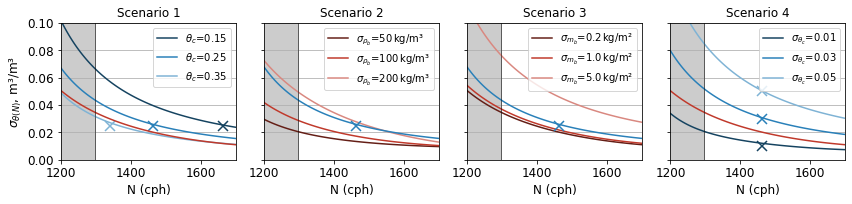

In [29]:
# 4 scenarios
# scenario 1: effect of calibration date
# scenario 2: effect of bulk density error
# scenario 3: effect of biomass error
# scenario 4: effect of calibration theta error

fc=0.4
avgn0 = 2302


# ALL
rhob_ = 1300.
sigma_rhob = 130
N1, N2 = 1200, 1700

# LOCAL
thcs = [0.15, 0.25, 0.35]
sigma_thc = 0.025

# GENERAL
fs_ = 1.
sigma_fs = get_sigma_fs(fs_, 1400, 48)
mb_ = 2
sigma_mb = 0.2
som_ = 0.06
sigma_som = 0.01
lw_ = 0.02
sigma_lw = 0.002
N0 = 2302
sigma_N0=19
#sigma_N0 = (n0suci - n0slci) / 2. / 1.96
    
plt.rc('font', **{'size'   : 12})
fig, ax = plt.subplots(1,4, figsize=(12,3), sharey=True)
ax = ax.ravel()
ymax = 0.2

# --------------------------------
# SCENARIO 1
plt.sca(ax[0])

for i, thc_ in enumerate(thcs):
    pars, sigmas = get_pars_n_sigmas_local(N0=avgn0, N1=N1, N2=N2, thc=thc_,
                                              rhob=rhob_, fs=1., sigma_thc=sigma_thc, sigma_rhob=sigma_rhob)
    sigma_th_N = sigma_th_eff(pars, sigmas)
    
    pl = plt.plot(pars["N"], sigma_th_N, color=lcols[i], label=r"$\theta_c$=%.2f" % thc_)
    plt.plot(pars["Nc"], sigma_thc, "kx", mew=1.5, color=lcols[i], ms=10, label=r"_dummy")


pars_general, sigmas_general = get_pars_n_sigmas_general(N0=avgn0, N1=N1, N2=N2, rhob=rhob_, fs=fs_, 
                                                         mb=mb_, som=som_, lw=lw_, sigma_N0=sigma_N0, 
                                                         sigma_rhob=sigma_rhob, sigma_mb=sigma_mb,
                                                         sigma_som=sigma_som, sigma_lw=sigma_lw)
sigma_th_N_general = sigma_th(pars_general, sigmas_general)
plt.plot(pars_general["N"], sigma_th_N_general, color=gcols[1], label="_dummy")
decorate(ax[0], fc=fc, rhob=rhob_)

# --------------------------------
# SCENARIO 2
plt.sca(ax[1])

for i, sigma_rhob_ in enumerate([50, 100, 200]):
    pars_general, sigmas_general = get_pars_n_sigmas_general(N0=avgn0, N1=N1, N2=N2, rhob=rhob_, fs=fs_, 
                                                             mb=mb_, som=som_, lw=lw_, sigma_N0=sigma_N0, 
                                                             sigma_rhob=sigma_rhob_, sigma_mb=sigma_mb,
                                                             sigma_som=sigma_som, sigma_lw=sigma_lw)
    sigma_th_N_general = sigma_th(pars_general, sigmas_general)
    plt.plot(pars_general["N"], sigma_th_N_general, color=gcols[i], label=r"$\sigma_{\rho_b}$=%d$\,$kg/m³" % sigma_rhob_)
    
pars, sigmas = get_pars_n_sigmas_local(N0=avgn0, N1=N1, N2=N2, thc=0.25,
                                          rhob=rhob_, fs=1., sigma_thc=sigma_thc, sigma_rhob=sigma_rhob_)
sigma_th_N = sigma_th_eff(pars, sigmas)
pl = plt.plot(pars["N"], sigma_th_N, color=lcols[1], label="_dummy")
plt.plot(pars["Nc"], sigma_thc, "kx", mew=1.5, color=lcols[1], ms=10, label=r"_dummy")

decorate(ax[1], fc=fc, rhob=rhob_, ylabel="")
plt.ylim(0,0.2)


# --------------------------------
# SCENARIO 3
plt.sca(ax[2])

for i, sigma_mb_ in enumerate([0.2, 1, 5]):
    pars_general, sigmas_general = get_pars_n_sigmas_general(N0=avgn0, N1=N1, N2=N2, rhob=rhob_, fs=fs_, 
                                                             mb=mb_, som=som_, lw=lw_, sigma_N0=sigma_N0, 
                                                             sigma_rhob=sigma_rhob, sigma_mb=sigma_mb_,
                                                             sigma_som=sigma_som, sigma_lw=sigma_lw)
    sigma_th_N_general = sigma_th(pars_general, sigmas_general)
    plt.plot(pars_general["N"], sigma_th_N_general, color=gcols[i], label=r"$\sigma_{m_b}$=%.1f$\,$kg/m²" % sigma_mb_)
    
pars, sigmas = get_pars_n_sigmas_local(N0=avgn0, N1=N1, N2=N2, thc=0.25,
                                          rhob=rhob_, fs=1., sigma_thc=sigma_thc, sigma_rhob=sigma_rhob_)
sigma_th_N = sigma_th_eff(pars, sigmas)
pl = plt.plot(pars["N"], sigma_th_N, color=lcols[1], label="_dummy")
plt.plot(pars["Nc"], sigma_thc, "kx", mew=1.5, color=lcols[1], ms=10, label="_dummy")

decorate(ax[2], fc=fc, rhob=rhob_, ylabel="")

# --------------------------------
# SCENARIO 4
plt.sca(ax[3])

for i, sigma_thc_ in enumerate([0.01, 0.03, 0.05]):
    pars, sigmas = get_pars_n_sigmas_local(N0=avgn0, N1=N1, N2=N2, thc=0.25,
                                          rhob=rhob_, fs=1., sigma_thc=sigma_thc_, sigma_rhob=sigma_rhob_)
    sigma_th_N = sigma_th_eff(pars, sigmas)
    pl = plt.plot(pars["N"], sigma_th_N, color=lcols[i], label=r"$\sigma_{\theta_c}$=%.2f" % sigma_thc_)
    plt.plot(pars["Nc"], sigma_thc_, "kx", mew=1.5, color=lcols[i], ms=10, label=r"_dummy")


pars_general, sigmas_general = get_pars_n_sigmas_general(N0=avgn0, N1=N1, N2=N2, rhob=rhob_, fs=fs_, 
                                                         mb=mb_, som=som_, lw=lw_, sigma_N0=sigma_N0, 
                                                         sigma_rhob=sigma_rhob, sigma_mb=sigma_mb,
                                                         sigma_som=sigma_som, sigma_lw=sigma_lw)
sigma_th_N_general = sigma_th(pars_general, sigmas_general)
plt.plot(pars_general["N"], sigma_th_N_general, color=gcols[1], label="_dummy")
    

decorate(ax[3], fc=fc, rhob=rhob_, ylabel="")



plt.ylim(0,0.10)

ax[0].set_title(r"Scenario 1", fontsize=12)
ax[1].set_title(r"Scenario 2", fontsize=12)
ax[2].set_title(r"Scenario 3", fontsize=12)
ax[3].set_title(r"Scenario 4", fontsize=12)

plt.tight_layout()



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button

In [32]:
%matplotlib notebook

<IPython.core.display.Javascript object>


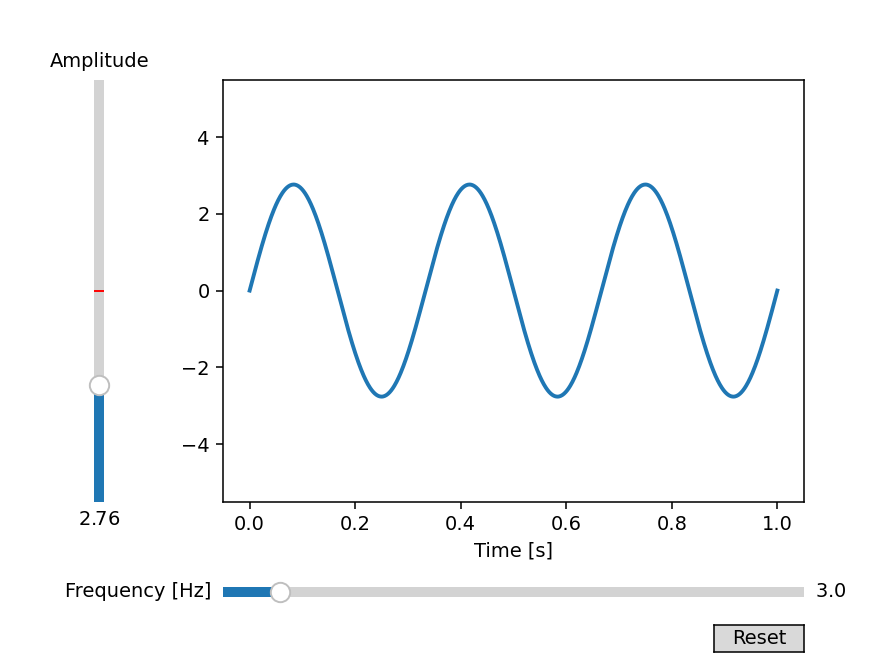

In [33]:
# The parametrized function to be plotted
def f(t, amplitude, frequency):
    return amplitude * np.sin(2 * np.pi * frequency * t)

t = np.linspace(0, 1, 1000)

# Define initial parameters
init_amplitude = 5
init_frequency = 3

# Create the figure and the line that we will manipulate
fig, ax = plt.subplots()
line, = ax.plot(t, f(t, init_amplitude, init_frequency), lw=2)
ax.set_xlabel('Time [s]')

# adjust the main plot to make room for the sliders
fig.subplots_adjust(left=0.25, bottom=0.25)

# Make a horizontal slider to control the frequency.
axfreq = fig.add_axes([0.25, 0.1, 0.65, 0.03])
freq_slider = Slider(
    ax=axfreq,
    label='Frequency [Hz]',
    valmin=0.1,
    valmax=30,
    valinit=init_frequency,
)

# Make a vertically oriented slider to control the amplitude
axamp = fig.add_axes([0.1, 0.25, 0.0225, 0.63])
amp_slider = Slider(
    ax=axamp,
    label="Amplitude",
    valmin=0,
    valmax=10,
    valinit=init_amplitude,
    orientation="vertical"
)


# The function to be called anytime a slider's value changes
def update(val):
    line.set_ydata(f(t, amp_slider.val, freq_slider.val))
    fig.canvas.draw_idle()


# register the update function with each slider
freq_slider.on_changed(update)
amp_slider.on_changed(update)

# Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
resetax = fig.add_axes([0.8, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', hovercolor='0.975')


def reset(event):
    freq_slider.reset()
    amp_slider.reset()
button.on_clicked(reset)

plt.show()